## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("./Ex1/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']= .ftse

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#del df_comp['spx']
#del df_comp['dax']
#del df_comp['ftse']
#del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## ARIMA(1,1,1)

In [8]:
model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 08 Jul 2020   AIC                          55215.333
Time:                        13:32:40   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

## Residuals of the ARIMA(1,1,1)

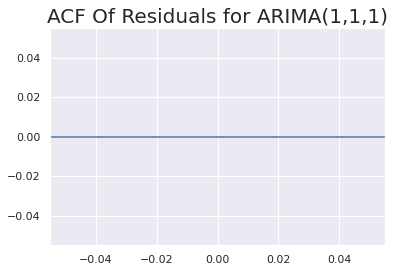

In [30]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show() 
# SE il grafico è piatto allora la computazione non è andata a buon fine
# probabilemnte a casusa dei valori mancanti. Probabilmente a causa dei 
# valori lasciati vacanti dall'integrazione.  

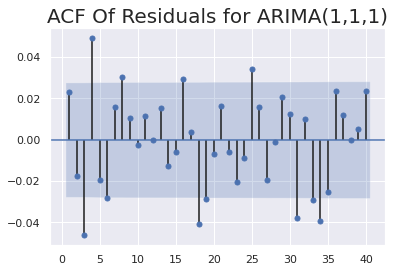

In [10]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40) # prendo gli elementi che partono da quello con indice 1
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

## Higher-Lag ARIMA Models

In [11]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

In [12]:
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMA(1,1,1):  	 LL =  -27603.66641276552 	 AIC =  55215.33282553104
ARIMA(1,1,2):  	 LL =  -27600.08186311539 	 AIC =  55210.16372623078
ARIMA(1,1,3):  	 LL =  -27590.424032580457 	 AIC =  55192.84806516091
ARIMA(2,1,1):  	 LL =  -27599.80748784704 	 AIC =  55209.61497569408
ARIMA(3,1,1):  	 LL =  -27592.055371703547 	 AIC =  55196.110743407095
ARIMA(3,1,2):  	 LL =  -27590.6608089723 	 AIC =  55195.3216179446


In [13]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_2, results_ar_1_i_1_ma_3)))


LLR test p-value = 0.0


In [14]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_1, results_ar_1_i_1_ma_3, DF = 2)))


LLR test p-value = 0.0


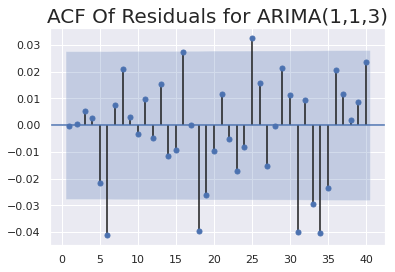

In [15]:
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,3)", size=20)
plt.show()

In [16]:
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit(start_ar_lags=11)
model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order=(6,1,3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit(start_ar_lags=11)

In [17]:
results_ar_5_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27586.512
Method:                       css-mle   S.D. of innovations             58.932
Date:                Wed, 08 Jul 2020   AIC                          55189.024
Time:                        13:32:55   BIC                          55241.193
Sample:                    01-10-1994   HQIC                         55207.305
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5664      0.690      0.820      0.412      -0.787       1.920
ar.L1.D.market_value     0.4011      0.159      2.530      0.011       0.090       0.712
ar.L2.D.market_value    -0.0445      0.016     -2.856      0.004      -0.075      -0.014
ar.L3.D.market_value    -0.0543      0.017     -3.163      0.002      -0.088      -0.021
ar.L4.D.market_value     0.0586      0.019      3.069      0.002       0.021       0.096
ar.L5.D.market_value    -0.0581      0.014     -4.118      0.000      -0.086      -0.030
ma.L1.D.market_value    -0.4214      0.158     -2.659      0.008      -0.732      -0.111
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7609           -0.0000j            1.7609           -0.5000
AR.2            1.4633           -0.8605j            1.6975           -0.0846
AR.3            1.4633           +0.8605j            1.6975            0.0846
AR.4           -0.0790           -1.8393j            1.8410           -0.2568
AR.5           -0.0790           +1.8393j            1.8410            0.2568
MA.1            2.3733           +0.0000j            2.3733            0.0000
-----------------------------------------------------------------------------
"""

In [18]:
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(6,1,3):  \t LL = ", results_ar_6_i_1_ma_3.llf, "\t AIC = ", results_ar_6_i_1_ma_3.aic)

ARIMA(1,1,3):  	 LL =  -27590.424032580457 	 AIC =  55192.84806516091
ARIMA(5,1,1):  	 LL =  -27586.511888128152 	 AIC =  55189.023776256305
ARIMA(6,1,3):  	 LL =  -27583.56532054728 	 AIC =  55189.13064109456


In [19]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_3, results_ar_6_i_1_ma_3, DF = 5)))


LLR test p-value = 0.018


In [20]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_5_i_1_ma_1, results_ar_6_i_1_ma_3, DF = 3)))


LLR test p-value = 0.117


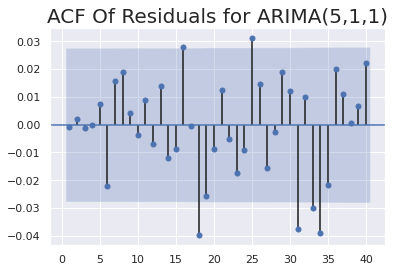

In [21]:
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,1,1)", size=20)
plt.show()

## Models with Higher Levels of Integration

In [22]:
df['delta_prices']=df.market_value.diff(1)

In [23]:
model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1))
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
results_delta_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 08 Jul 2020   AIC                          55215.333
Time:                        13:32:56   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.delta_prices     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.delta_prices    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
sts.adfuller(df.delta_prices[1:])

(-32.24409349570743,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

In [25]:
model_ar_1_i_2_ma_1 = ARIMA(df.market_value, order=(1,2,1))
results_ar_1_i_2_ma_1 = model_ar_1_i_2_ma_1.fit(start_ar_lags=10)
results_ar_1_i_2_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.market_value   No. Observations:                 5019
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -27614.158
Method:                       css-mle   S.D. of innovations             59.272
Date:                Wed, 08 Jul 2020   AIC                          55236.316
Time:                        13:32:58   BIC                          55262.400
Sample:                    01-11-1994   HQIC                         55245.457
                         - 04-05-2013                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0001      0.001     -0.202      0.840      -0.001       0.001
ar.L1.D2.market_value    -0.0178      0.014     -1.261      0.207      -0.045       0.010
ma.L1.D2.market_value    -1.0000      0.001  -1717.796      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -56.1840           +0.0000j           56.1840            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

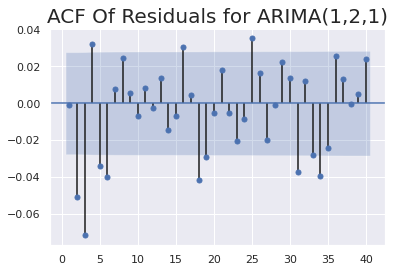

In [26]:
df['res_ar_1_i_2_ma_1'] = results_ar_1_i_2_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_2_ma_1[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,2,1)",size=20)
plt.show()

## ARIMAX 

In [27]:
model_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog = df.spx, order=(1,1,1))
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
results_ar_1_i_1_ma_1_Xspx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Wed, 08 Jul 2020   AIC                          55217.112
Time:                        13:33:01   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.538
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5884      2.655     -0.222      0.825      -5.791       4.615
spx                      0.0011      0.002      0.451      0.652      -0.004       0.006
ar.L1.D.market_value     0.7462      0.070     10.602      0.000       0.608       0.884
ma.L1.D.market_value    -0.7923      0.064    -12.305      0.000      -0.918      -0.666
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3400           +0.0000j            1.3400            0.0000
MA.1            1.2622           +0.0000j            1.2622            0.0000
-----------------------------------------------------------------------------
"""

## SARIMAX

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
model_sarimax = SARIMAX(df.market_value, exog = df.spx, order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.661
Date:                           Wed, 08 Jul 2020   AIC                          53439.323
Time:                                   13:33:31   BIC                          53484.973
Sample:                               01-07-1994   HQIC                         53455.319
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7143      0.035     76.530      0.000       2.645       2.784
ar.L1          0.9999      0.000   3030.491      0.000       0.999       1.001
ma.L1         -0.3114      0.009    -33.592      0.000      -0.330      -0.293
ar.S.L5        0.9671      0.006    161.939      0.000       0.955       0.979
ar.S.L10       0.0327      0.006      5.860      0.000       0.022       0.044
ma.S.L5       -0.9994      0.007   -141.009      0.000      -1.013      -0.986
sigma2      2459.8686     27.932     88.067      0.000    2405.123    2514.614
===================================================================================
Ljung-Box (Q):                       95.51   Jarque-Bera (JB):              4200.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""